In [ ]:
# The idea of UODEs is to supply our model with as much 
# prior information about its structure as possible using
# ODEs, and replace the unknown parts with NNs.
# After training NNs, we can do what?

In [16]:
using DifferentialEquations
using OrdinaryDiffEq 
using ModelingToolkit
using DataDrivenDiffEq 
using Pkg; Pkg.status("DataDrivenDiffEq") # Make sure this is v0.3.0
using LinearAlgebra, DiffEqSensitivity, Optim 
using DiffEqFlux, Flux 
using Plots; gr() ; # Set GR backend for plots (other options e.g pyplot or plotly)

Status `/run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/Project.toml`
  [2445eb08] DataDrivenDiffEq v0.3.0


First we will solve the Lotka-Volterra equations for a population of rabbits $R$ and wolves $W$:
\begin{align}
\frac{dR}{dt} &= \alpha R - \beta R W \\
\frac{dW}{dt} &= \gamma R W - \delta W 
\end{align}


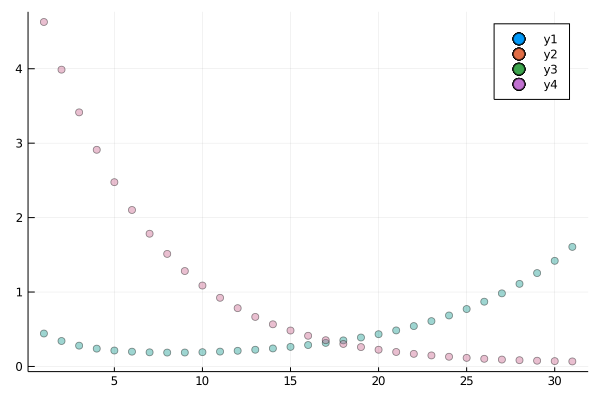

In [52]:
# Solve the LV equations
# Define gradients
function lotka_volterra!(du,u,p,t) # ! means function modifies inputs in-place for efficiency
    R,W = u 
    α,β,γ,δ = p
    du[1] = dR = α*R - β*R*W
    du[2] = dW = γ*R*W - δ*W
end

# Set Float32 initial conditions and params
tspan = (0.0f0,3.0f0)
u0 = Float32[0.44249296,4.6280594]
paramsODE = Float32[1.3,0.9,0.8,1.8]
prob = ODEProblem(lotka_volterra!,u0,tspan,paramsODE)
sol = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat=0.1); 

# Add tiny amount of noise to avoid overfitting (apparently important?)
cleandata = Array(sol)
noisy_data = cleandata + Float32(1e-5)*randn(eltype(cleandata),size(cleandata))
scatter(cleandata',alpha=0.25) 
scatter!(noisy_data',alpha=0.25) # This is our 'training data', trajectories over a limited range

Now let's suppose we do not know the cross terms. We can define a mixed ODE-NN model, a so-called 'universial ODE', which replaces those terms by a black box neural network:
\begin{align}
\frac{dR}{dt} &= \alpha R + NN(R,W,\theta) \\
\frac{dW}{dt} &= NN(R,W,\theta) - \delta W 
\end{align}


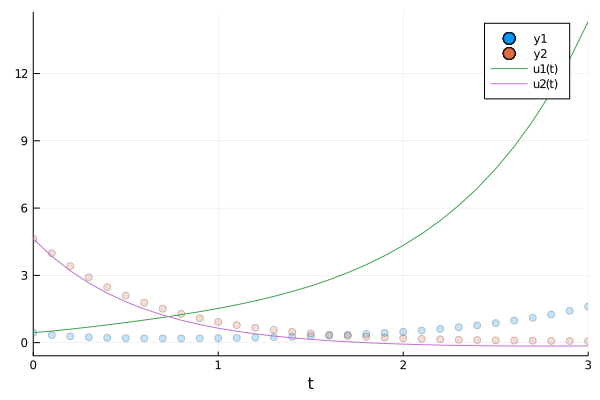

In [53]:
ann = FastChain(FastDense(2,32,tanh),FastDense(32,32,tanh),FastDense(32,2))
p = initial_params(ann)

function dudt(du,u,p,t)
    R,W = u
    α,β,γ,δ = paramsODE # This assumes we already know α and δ
    z = ann(u,p)
    du[1] = α*R + z[1] # ODE term + ANN term
    du[2] = z[2] - δ*W
end

prob_nn = ODEProblem(dudt,u0,tspan,p)
s = concrete_solve(prob_nn,Tsit5(),u0=u0,p=p,saveat=sol.t)

# Our untrained UODE
scatter(sol.t,noisy_data',alpha=0.25)
plot!(s)

loss: 6.16: 100%|█████████████████████████████████████████| Time: 0:00:17
┌ Info: Saved animation to 
│   fn = /run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/notebooks/fit_UODE.gif
└ @ Plots /home/nadanai/.julia/packages/Plots/LWw1t/src/animation.jl:104


Plots.AnimatedGif("/run/media/Storage HD/Nadanai/Archlinux/Repos/julia-sciML-resources/notebooks/fit_UODE.gif")
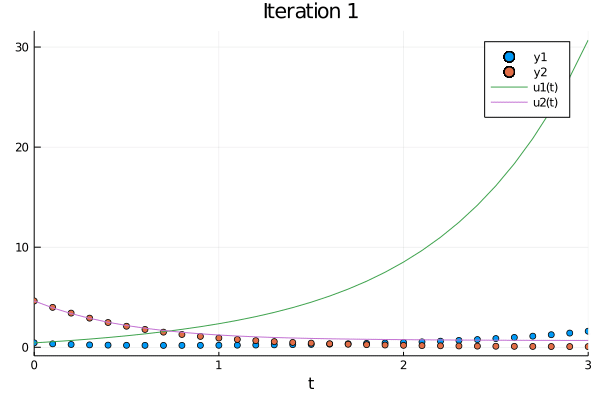

In [54]:
# Now let's train

function predict(θ)
    Array(concrete_solve(prob_nn,Vern7(),u0,θ,saveat=sol.t,
                        abstol=1e-6, reltol=1e-6))
end

function loss(θ)
    pred = predict(θ)
    sum(abs2, noisy_data.-pred),pred
end

frames = []
losses = []
function save_callback(θ,l,pred)
    mod_prob = remake(prob_nn,p=θ)
    mod_sol = solve(mod_prob, saveat=0.1)
    push!(frames,mod_sol)
    push!(losses,l)
    false
end

res1 = DiffEqFlux.sciml_train(loss,pinit,ADAM(0.05),cb=save_callback,maxiters=100)
res2 = DiffEqFlux.sciml_train(loss,res1.minimizer,BFGS(initial_stepnorm=0.01),cb=save_callback, maxiters=10000)

# Look at animation
anim = @animate for i in 1:length(frames)
    scatter(sol.t,noisy_data')
    plot!(frames[i], title="Iteration $i")
end

gif(anim,"fit_UODE.gif",fps=15)

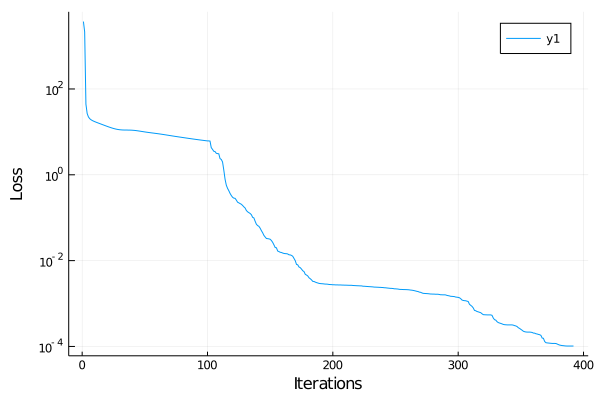

In [55]:
# Plot losses
plot(losses,yaxis=:log,xlabel="Iterations",ylabel="Loss")

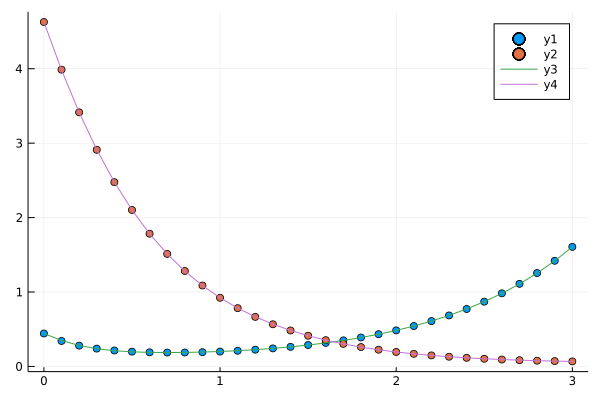

In [56]:
# Final plot of fit:
NNsolution = predict(res2.minimizer) # final parameters
scatter(sol.t,noisy_data') # Data
plot!(sol.t, NNsolution') # Fitted solution

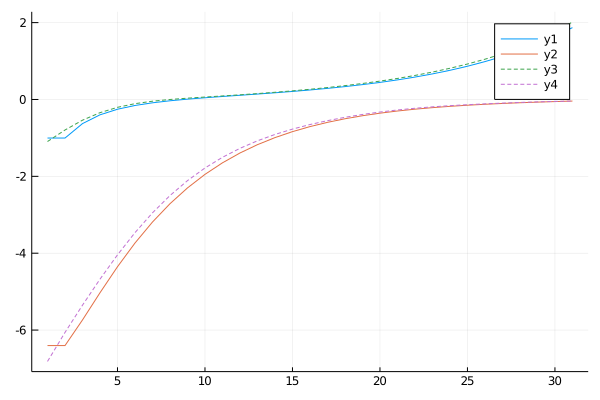

In [57]:
# We have numerically learned the RHS of our UODE, which corresponds
# to derivatives. Let's see this explicitly

# The derivatives can be directly read out of our ODE solution
# using sol(sol.t,Val{1})
DX = Array(sol(sol.t,Val{1}))
# We do the same to get the derivatives from our UODE solution
# by first solving it then extracting the derivatives
prob_nn2 = ODEProblem(dudt,u0,tspan,res2.minimizer)
solUODE = solve(prob_nn2,Tsit5())
DXUODE = Array(solUODE(sol.t,Val{1}))
plot(DX') # True derivatives
plot!(DXUODE',ls=:dash) # Learned derivatives

# Now we will convert the derivatives back to algebraic form
# using sparse regression

### Convert NNs back to algebra using sparse regression

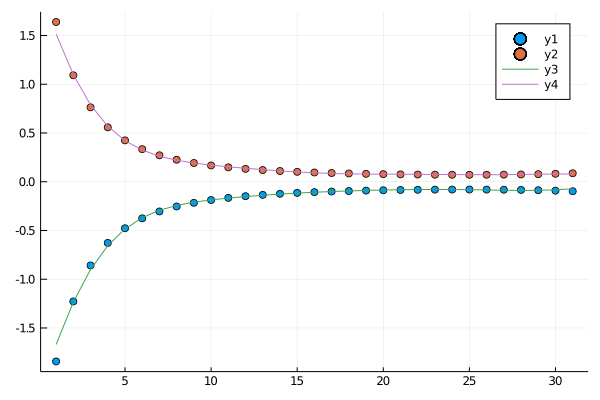

In [59]:
# The output of our ANN are the terms z[1] and z[2]
# for which we would like the algebraic form.
# The ground truth is 
# z[1] = -βu[1]u[2]
# z[2] = γu[1]u[2]

X = noisy_data
α,β,γ,δ = paramsODE
L = [-β*(X[1,:].*X[2,:])';γ*(X[1,:].*X[2,:])']
L̂ = ann(X,res2.minimizer) # Run ANN to generate outputs L̂
scatter(L')
plot!(L̂') # Missing terms

In [60]:
# We use ModelingTookit to generate a library of possible functions

@variables u[1:2] # create a basis of two variables
polys = Operation[1]
for i ∈ 1:5 # then populate a library of polynomials
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i!=j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

hh = [cos.(u)...; sin.(u)...; polys...] # Add some trig functions
basis = Basis(hh,u) # convert polynomials to basis
println(basis) # These are all the possible functions in the libary

# Rational functions cannot be defined this way.
# Requires implicit SInDy. 

┌ Warning: `simplify_constants(ex)` is deprecated, use `simplify(ex)` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:631 [inlined]
└ @ Core ./broadcast.jl:631
┌ Warning: `simplify_constants(ex)` is deprecated, use `simplify(ex)` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:631 [inlined]
└ @ Core ./broadcast.jl:631
┌ Warning: `simplify_constants(ex)` is deprecated, use `simplify(ex)` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:631 [inlined]
└ @ Core ./broadcast.jl:631
┌ Warning: `solve(ex)` is deprecated in JuliaVariables 0.2.x. Please use `solve!(ex)` instead.  `solve(ex)`, which currently mutates `ex` in-place, will be re-introduced in 0.3 as a non-mutating variant.
│   caller = mk_function(::Module, ::Expr) at GeneralizedGenerated.jl:22
└ @ GeneralizedGenerated /home/nadanai/.julia/packages/GeneralizedGenerated/IobaZ/src/GeneralizedGenerated.jl:22


29 dimensional basis in ["u₁", "u₂"]
f_1 = cos(u₁)
f_2 = cos(u₂)
f_3 = sin(u₁)
f_4 = sin(u₂)
f_5 = ModelingToolkit.Constant(1)
f_6 = u₁
f_7 = u₂
f_8 = u₂ ^ 2 * u₁
f_9 = u₂ ^ 3 * u₁
f_10 = u₂ ^ 4 * u₁
f_11 = u₂ ^ 5 * u₁
f_12 = u₁ * u₂
f_13 = u₁ ^ 2
f_14 = u₂ ^ 2
f_15 = u₁ ^ 2 * u₂ ^ 3
f_16 = u₁ ^ 2 * u₂ ^ 4
f_17 = u₁ ^ 2 * u₂ ^ 5
f_18 = u₁ ^ 2 * u₂ ^ 2
f_19 = u₁ ^ 3
f_20 = u₂ ^ 3
f_21 = u₁ ^ 3 * u₂ ^ 4
f_22 = u₁ ^ 3 * u₂ ^ 5
f_23 = u₁ ^ 3 * u₂ ^ 3
f_24 = u₁ ^ 4
f_25 = u₂ ^ 4
f_26 = u₁ ^ 4 * u₂ ^ 5
f_27 = u₁ ^ 4 * u₂ ^ 4
f_28 = u₁ ^ 5
f_29 = u₂ ^ 5



In [63]:
# Carry out sparse regression using SInDy
# Here we need DataDrivenDiffEq = v0.3.0
# Code will not work for later versions... to be updated

opt = SR3() # choose optimizer
λ = exp10.(-6:0.1:2) # choose threshold
f_target(x, w)= iszero(x[1]) ? Inf : norm(w.*x, 2)

# Tell me which algebraic equations best describes NN output
# We call the algorithm on the NN output L̂
Ψ = SInDy(X[:, 2:end], L̂[:, 2:end], basis, λ,  
    opt = opt, maxiter = 10000, normalize = true, 
    denoise = true, f_target = f_target) 

println(Ψ)
print_equations(Ψ) # Find equations
p̂ = parameters(Ψ) # p1 and p2, ground truth = [-0.9,0.8]

┌ Warning: `simplify_constants(ex)` is deprecated, use `simplify(ex)` instead.
│   caller = push!(::Basis{Array{Any,1},Array{Operation,1},Array{Operation,1},Operation}, ::Operation) at basis.jl:92
└ @ DataDrivenDiffEq /home/nadanai/.julia/packages/DataDrivenDiffEq/nNr4H/src/basis.jl:92


Sparse Identification Result
No. of Parameters : 2
Active terms : 2
   Equation 1 : 1
   Equation 2 : 1
Overall error (L2-Norm) : 0.40368107
   Equation 1 : 0.27142856
   Equation 2 : 0.13225251
AICC :
   Equation 1 : 7.6606703
   Equation 2 : 10.536613

SR3{Float64,UnionAll}(0.031547867224009665, 1.0, ProximalOperators.NormL1) did not converge after 10000 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = p₁ * u₁ * u₂
du₂ = p₂ * u₁ * u₂


2-element Array{Float32,1}:
 -0.7853855
  0.74533355

Float32[1.2999978, 1.800001, -0.9, 0.8000127]


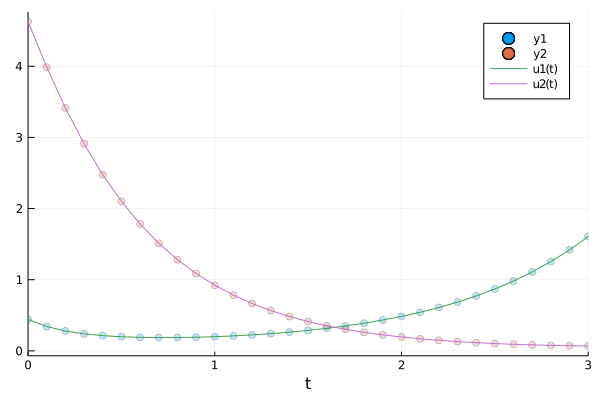

In [70]:
# We found a basis, now construct our algebraic solution and 
# find best fit parameters using an optimizer

unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys)
# Our purely algebraic ODE system
function approx(du, u, p, t)
    # Add SInDy Term. NB params in different order
    α, δ, β, γ = p
    z = unknown_eq(u, [β; γ], t)
    du[1] = α*u[1] + z[1]
    du[2] = -δ*u[2] + z[2]
end

pinit = [paramsODE[[1,4]]; p̂] # Add initial SInDy params 
a_prob = ODEProblem(approx,u0,tspan,pinit)

# Make our loss function
function loss(p)
    mod_prob = remake(a_prob,p=p)
    mod_sol = solve(mod_prob,Tsit5(),saveat=0.1,verbose=false) 
    sum(abs2, Array(mod_sol)-noisy_data) 
end

res = DiffEqFlux.sciml_train(loss,pinit,BFGS()) # Minimize loss using BFGS optimizer. 
paramsfinal = res.minimizer
println(paramsfinal) # Final params

fin_prob = remake(a_prob,p=paramsfinal)
fin_sol = solve(fin_prob,Tsit5(),saveat=0.1)

scatter(sol.t,noisy_data',alpha=0.25)
plot!(fin_sol)


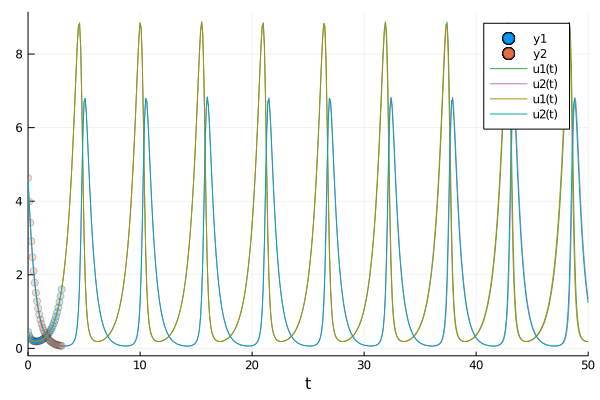

In [73]:
# The power of this is best illustrated by extrapolation:

t_long = (0.0,50.0)
prob = ODEProblem(approx,u0,t_long,paramsfinal)
extrapsol = solve(prob,Tsit5(),saveat=0.1)
scatter(sol.t,noisy_data',alpha=0.25) # First show training data
plot!(extrapsol,ls=:dash) # Then extrapolation

prob_groundtruth = ODEProblem(lotka_volterra!,u0,t_long,paramsODE)
sol_groundtruth = solve(prob_groundtruth, Tsit5(), saveat=extrapsol.t); 
plot!(sol_groundtruth) # Then true dynamics
# Sindy successfully extrapolates from limited training data
